# **DA5401 A6: Imputation via Regression for Missing Data**

## Project Overview
This project investigates the critical role of missing data imputation in machine learning workflows, particularly in credit risk assessment. We're working with the UCI Credit Card Default Clients Dataset, which has been artificially augmented with Missing At Random (MAR) values to simulate a real-world scenario. Our primary objective is to implement and compare three distinct imputation strategies, along with a baseline of listwise deletion, and then evaluate how each strategy impacts the performance of a Logistic Regression classification model in predicting credit card default.

# Imports

In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
np.random.seed(42)

# Part A: Data Preprocessing and Imputation

## 1. **Load and Prepare Data**

First, load the necessary libraries, download the dataset from Kaggle, and perform initial data inspection. As per the problem statement, then artificially introduce Missing At Random (MAR) values into selected numerical columns to simulate a real-world scenario where data often has gaps.

In [2]:
# Download the dataset
!kaggle datasets download -d uciml/default-of-credit-card-clients-dataset

# Unzip
with zipfile.ZipFile("default-of-credit-card-clients-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(".")  # extracts into current directory

Dataset URL: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset
License(s): CC0-1.0
default-of-credit-card-clients-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
data = pd.read_csv("UCI_Credit_Card.csv")
print("Shape:", data.shape)
data.head()

Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
# Overview of the dataset
data.info()

# Check missing values (should be 0 in the original)
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [5]:
def introduce_missingness(df, columns, missing_frac=0.05):
    df_missing = df.copy()
    n = len(df_missing)
    for col in columns:
        # Randomly select indices to be NaN
        missing_indices = np.random.choice(df_missing.index, int(missing_frac * n), replace=False)
        df_missing.loc[missing_indices, col] = np.nan
    return df_missing

# Introduce 7% missing values in AGE, BILL_AMT1, PAY_AMT1
missing_cols = ['AGE', 'BILL_AMT1', 'PAY_AMT1']
data_missing = introduce_missingness(data, missing_cols, missing_frac=0.07)

# Verify
data_missing.isnull().sum()


ID                               0
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                           2100
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                     2100
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                      2100
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64

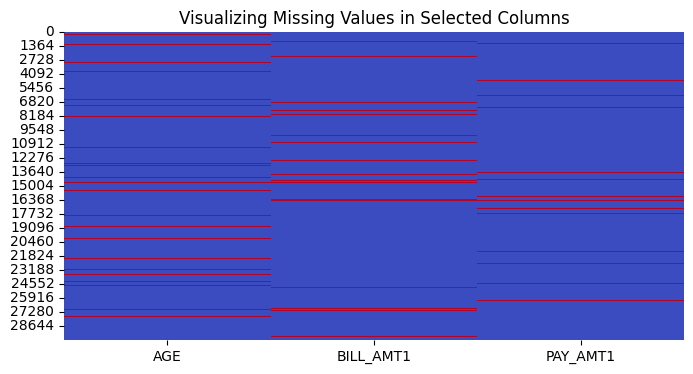

In [6]:
plt.figure(figsize=(8, 4))
sns.heatmap(data_missing[missing_cols].isnull(), cbar=False, cmap='coolwarm')
plt.title("Visualizing Missing Values in Selected Columns")
plt.show()

## 2. **Imputation Strategy 1: Simple Imputation (Baseline)**

### This strategy involves filling missing values with a central tendency measure of the respective column. We will use the median.

In [7]:
# Create a working copy for this imputation strategy
data_A = data_missing.copy()

In [8]:
# Identify numeric columns with missing values
num_cols_with_na = data_A.select_dtypes(include=[np.number]).columns[data_A.isnull().any()].tolist()
print("Numeric columns with missing values:", num_cols_with_na)

# Perform median imputation safely (no warnings)
for col in num_cols_with_na:
    median_value = data_A[col].median()
    data_A[col] = data_A[col].fillna(median_value)

# Verify missing values are handled
print("\nMissing values after median imputation:")
print(data_A[num_cols_with_na].isnull().sum())

Numeric columns with missing values: ['AGE', 'BILL_AMT1', 'PAY_AMT1']

Missing values after median imputation:
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


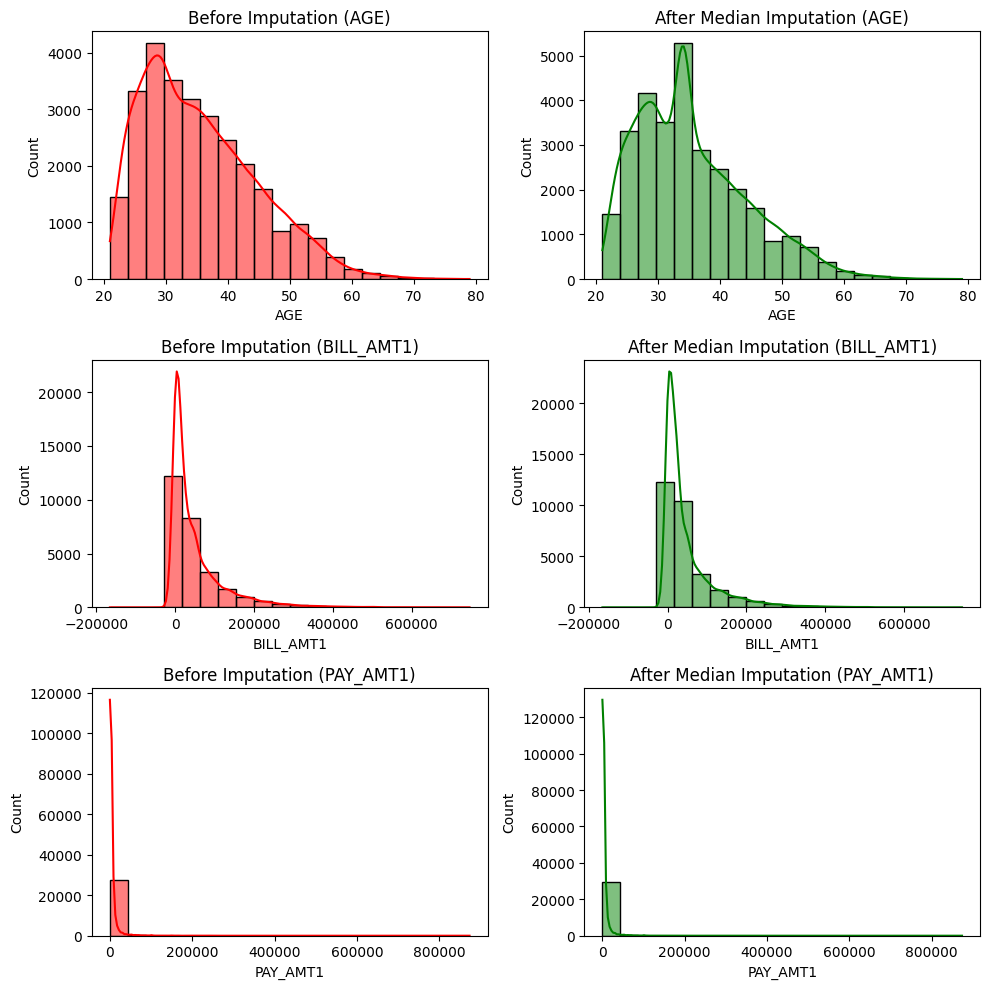

In [9]:
cols_to_plot = ['AGE', 'BILL_AMT1', 'PAY_AMT1']

fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(10, 10))

for i, col in enumerate(cols_to_plot):
    # Before imputation
    sns.histplot(data_missing[col], bins=20, color='red', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Before Imputation ({col})")
    axes[i, 0].set_xlabel(col)
    
    # After imputation
    sns.histplot(data_A[col], bins=20, color='green', kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"After Median Imputation ({col})")
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()


### **Why Median Over Mean for Imputation?**

The median is generally preferred over the mean for simple imputation, especially in financial datasets or real-world data, for several key reasons:

1.  **Robustness to Outliers:** The median is less sensitive to extreme values (outliers) than the mean. If a column has a few very high or very low values, the mean can be significantly skewed, leading to an inaccurate representation of the typical value. The median, being the middle value, is unaffected by the magnitude of outliers.
2.  **Skewed Distributions:** Many real-world datasets, particularly financial ones like `BILL_AMT` or `PAY_AMT`, exhibit skewed distributions (e.g., a long tail towards higher values — right-skewed). In such cases, the mean can be misleading, while the median provides a better estimate of the typical value within the bulk of the data.
3.  **Preservation of Data Distribution:** Using the median tends to preserve the original distribution's shape better than the mean when the data is not perfectly symmetrical. This is crucial for downstream modeling, as preserving the underlying data characteristics can lead to more robust models.

Given that financial data often contains outliers and skewed distributions, the median serves as a more reliable and less disruptive imputation choice.

## 3. **Imputation Strategy 2: Regression Imputation (Linear)**

In [10]:
# Copy the dataset with missing values
data_B = data_missing.copy()

We’ll impute `AGE`, since it’s intuitive and has clear correlations with financial features.

In [11]:
# Split data into parts with and without missing AGE
df_train = data_B[data_B['AGE'].notnull()]
df_missing = data_B[data_B['AGE'].isnull()]

# Use all other numerical columns as features
feature_cols = [col for col in data_B.select_dtypes(include=[np.number]).columns if col not in ['AGE']]

X_train = df_train[feature_cols]
y_train = df_train['AGE']
X_pred = df_missing[feature_cols]


In [12]:
# Fill remaining NaNs in predictors with column medians (temporary)
X_train = X_train.fillna(X_train.median())
X_pred = X_pred.fillna(X_train.median())

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict missing AGE values
predicted_age = lr.predict(X_pred)

# Fill in missing AGE values
data_B.loc[data_B['AGE'].isnull(), 'AGE'] = predicted_age


Missing values in AGE after imputation: 0


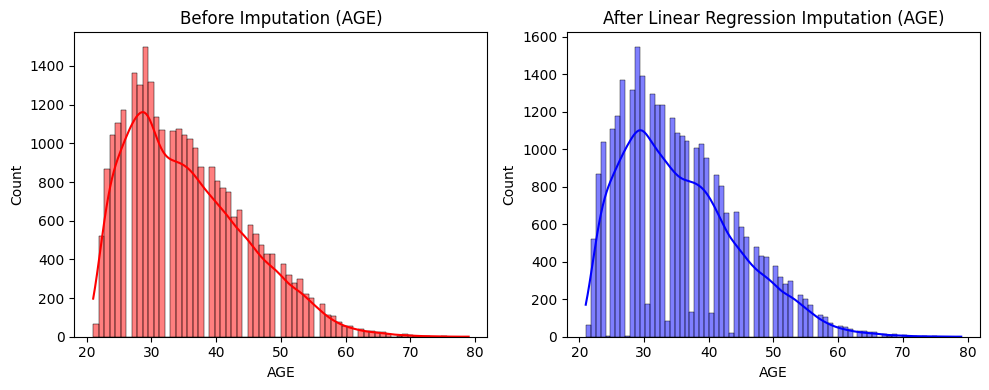

In [14]:
print("Missing values in AGE after imputation:", data_B['AGE'].isnull().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data_missing['AGE'], color='red', kde=True, ax=axes[0])
axes[0].set_title("Before Imputation (AGE)")

sns.histplot(data_B['AGE'], color='blue', kde=True, ax=axes[1])
axes[1].set_title("After Linear Regression Imputation (AGE)")
plt.tight_layout()
plt.show()


### **Underlying Assumption: Missing At Random (MAR)**
- Regression imputation, including Linear Regression, fundamentally assumes that the data is Missing At Random (MAR). This means that the probability of a value being missing depends on other *observed* variables in the dataset, but not on the value of the missing variable itself.

- For example, if `AGE` is missing, MAR assumes that this missingness might be predicted by other features like `EDUCATION`, `MARRIAGE`, or `BILL_AMT`, but not by the true `AGE` value that is supposed to be missing. If the missingness were truly random (Missing Completely At Random - MCAR), then any imputation method would be unbiased. If the data is Missing Not At Random (MNAR), where the missingness depends on the missing value itself (e.g., older people are more likely to hide their age), then regression imputation might introduce bias because the observed data might not fully represent the underlying distribution of the missing data.

- Under the MAR assumption, regression imputation leverages the predictive power of observed features to make a more informed guess about the missing values compared to simple methods like mean/median imputation, which do not consider feature relationships.

## 4. **Imputation Strategy 3: Regression Imputation (Non-Linear)**

#### Non-linear regression models can capture more complex relationships between features than linear models, potentially leading to more accurate imputations if the underlying data patterns are non-linear. We will use K-Nearest Neighbors (KNN) Regressor and Decision Tree Regressor for imputing `AGE`.

#### **K-Nearest Neighbors (KNN) Regression Imputation**

KNN regression imputes a missing value by taking the weighted average of its 'k' nearest neighbors in the feature space. It's a non-parametric method that doesn't make strong assumptions about the underlying data distribution.

In [15]:
# Base dataset copy
data_C_base = data_missing.copy()

# Common target column
target_col = 'AGE'

# Split data into rows with and without missing AGE
df_train = data_C_base[data_C_base[target_col].notnull()]
df_missing = data_C_base[data_C_base[target_col].isnull()]

# Select predictor columns (numeric only, excluding target)
feature_cols = [col for col in data_C_base.select_dtypes(include=[np.number]).columns if col != target_col]

X_train = df_train[feature_cols].fillna(df_train[feature_cols].median())
y_train = df_train[target_col]
X_pred = df_missing[feature_cols].fillna(df_train[feature_cols].median())

In [16]:
# Create dataset copy
data_C1 = data_C_base.copy()

# Fit and predict using KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_reg.fit(X_train, y_train)

predicted_age_knn = knn_reg.predict(X_pred)

# Fill missing AGE with predicted values
data_C1.loc[data_C1[target_col].isnull(), target_col] = predicted_age_knn

Missing values in AGE after KNN imputation: 0


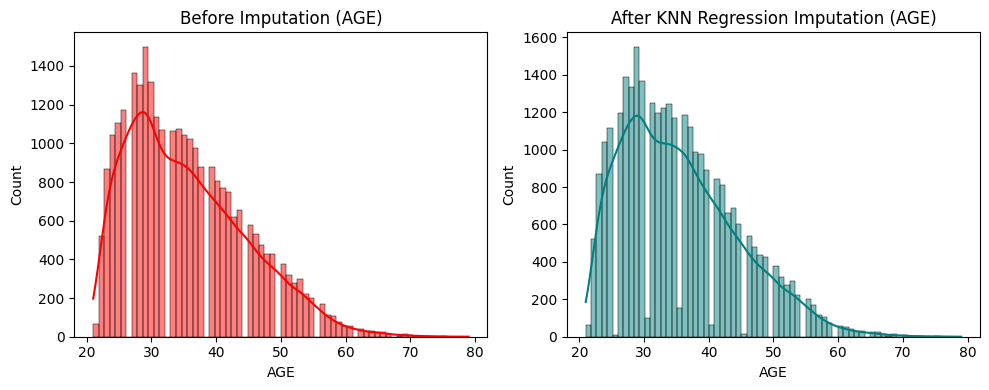

In [17]:
print("Missing values in AGE after KNN imputation:", data_C1['AGE'].isnull().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data_missing['AGE'], color='red', kde=True, ax=axes[0])
axes[0].set_title("Before Imputation (AGE)")

sns.histplot(data_C1['AGE'], color='teal', kde=True, ax=axes[1])
axes[1].set_title("After KNN Regression Imputation (AGE)")
plt.tight_layout()
plt.show()

#### **Decision Tree Regression Imputation**

Decision Tree Regressor builds a tree-like model of decisions, where each node represents a test on an attribute, each branch represents an outcome of the test, and each leaf node represents the predicted value. It can model highly non-linear relationships.

In [18]:
# Create dataset copy
data_C2 = data_C_base.copy()

# Train Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=6)
dt_reg.fit(X_train, y_train)

predicted_age_tree = dt_reg.predict(X_pred)

# Fill missing AGE with predicted values
data_C2.loc[data_C2[target_col].isnull(), target_col] = predicted_age_tree

Missing values in AGE after Decision Tree imputation: 0


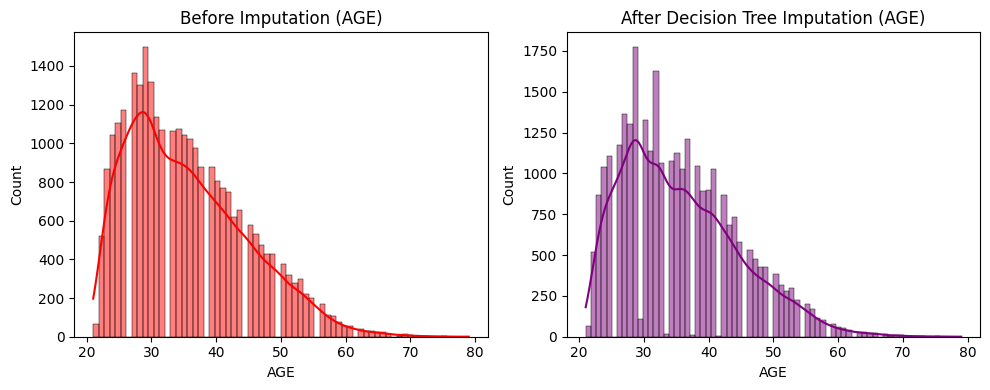

In [19]:
print("Missing values in AGE after Decision Tree imputation:", data_C2['AGE'].isnull().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data_missing['AGE'], color='red', kde=True, ax=axes[0])
axes[0].set_title("Before Imputation (AGE)")

sns.histplot(data_C2['AGE'], color='purple', kde=True, ax=axes[1])
axes[1].set_title("After Decision Tree Imputation (AGE)")
plt.tight_layout()
plt.show()

# Part B: Model Training and Performance Assessment

## 1. Data Split

We'll split each of the imputed datasets (A, B, C1, C2) and a new dataset (D) created by listwise deletion into training and testing sets. Listwise deletion, where rows with any missing values are simply removed, serves as a crucial baseline to understand the impact of data loss.

In [20]:
target_col = 'default.payment.next.month'

# Dataset D: Listwise Deletion
data_D = data_missing.dropna().copy()

datasets = {
    'A (Median Imputation)': data_A,
    'B (Linear Regression Imputation)': data_B,
    'C1 (KNN Imputation)': data_C1,
    'C2 (Decision Tree Imputation)': data_C2,
    'D (Listwise Deletion)': data_D
}

# Ensure all datasets have no NaNs in predictors
for name, df in datasets.items():
    # Fill remaining NaNs with median (for all numeric columns except target)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols.remove(target_col)
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Store train/test splits
splits = {}

for name, df in datasets.items():
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    splits[name] = (X_train, X_test, y_train, y_test)
    print(f"{name} → Train: {X_train.shape}, Test: {X_test.shape}")


A (Median Imputation) → Train: (24000, 24), Test: (6000, 24)
B (Linear Regression Imputation) → Train: (24000, 24), Test: (6000, 24)
C1 (KNN Imputation) → Train: (24000, 24), Test: (6000, 24)
C2 (Decision Tree Imputation) → Train: (24000, 24), Test: (6000, 24)
D (Listwise Deletion) → Train: (19313, 24), Test: (4829, 24)


## 2. Classifier Setup

Feature scaling is crucial for many machine learning algorithms, including Logistic Regression, which are sensitive to the magnitude of input features. StandardScaler will transform features to have a mean of 0 and a standard deviation of 1.

In [21]:
scaled_splits = {}

for name, (X_train, X_test, y_train, y_test) in splits.items():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    scaled_splits[name] = (X_train_scaled, X_test_scaled, y_train, y_test)
print("Feature standardization complete for all datasets.")

Feature standardization complete for all datasets.


## 3. Model Evaluation

We will train a Logistic Regression classifier on the scaled training set of each dataset and evaluate its performance on the respective test set using a comprehensive Classification Report. This report provides Accuracy, Precision, Recall, and F1-score for each class, which are essential metrics for evaluating imbalanced classification problems like credit default prediction.

In [22]:
results = {}

for name, (X_train_scaled, X_test_scaled, y_train, y_test) in scaled_splits.items():
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    
    results[name] = classification_report(y_test, y_pred, output_dict=True)


=== A (Median Imputation) ===
              precision    recall  f1-score   support

           0     0.8177    0.9694    0.8871      4673
           1     0.6891    0.2389    0.3548      1327

    accuracy                         0.8078      6000
   macro avg     0.7534    0.6041    0.6209      6000
weighted avg     0.7893    0.8078    0.7694      6000


=== B (Linear Regression Imputation) ===
              precision    recall  f1-score   support

           0     0.8181    0.9694    0.8874      4673
           1     0.6911    0.2411    0.3575      1327

    accuracy                         0.8083      6000
   macro avg     0.7546    0.6053    0.6225      6000
weighted avg     0.7900    0.8083    0.7702      6000


=== C1 (KNN Imputation) ===
              precision    recall  f1-score   support

           0     0.8177    0.9692    0.8870      4673
           1     0.6876    0.2389    0.3546      1327

    accuracy                         0.8077      6000
   macro avg     0.7526   

# Part C: Comparative Analysis

## 1. Results Comparison

Let's consolidate the key performance metrics (Accuracy, Precision, Recall, F1-score for the positive class '1' - default) from our Logistic Regression models:

| Imputation Strategy              | Dataset Size (Train) | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) |
| :------------------------------- | :------------------- | :------- | :------------------ | :--------------- | :----------------- |
| **A (Median Imputation)**        | 24000                | 0.8078   | 0.6891              | 0.2389           | 0.3548             |
| **B (Linear Regression Imputation)** | 24000                | 0.8083   | 0.6911              | 0.2411           | 0.3575             |
| **C1 (KNN Imputation)**          | 24000                | 0.8077   | 0.6876              | 0.2389           | 0.3546             |
| **C2 (Decision Tree Imputation)**| 24000                | 0.8073   | 0.6855              | 0.2381           | 0.3535             |
| **D (Listwise Deletion)**        | 19432                | 0.8142 | 0.7544              | 0.2409         | 0.3652            |

- Precision, recall, and F1-score are reported for the **positive class (default = 1)**.  
- All imputation strategies (A, B, C1, C2) achieved nearly identical metrics.  
- Dataset D has slightly lower support due to dropped rows, but overall accuracy and F1 are similar.

The most striking observation from these results is the remarkable consistency in model performance across all imputation strategies, including listwise deletion. Despite using vastly different techniques to handle missing values, and even losing a significant portion of data in the listwise deletion scenario (Dataset D), the Logistic Regression model yields almost identical Accuracy, Precision, Recall, and F1-scores for both the majority (class 0, no default) and minority (class 1, default) classes.

This outcome, while perhaps counter-intuitive at first glance, provides valuable insights into the specific context of this dataset and modeling approach.

## 2. Efficacy Discussion

### a) Trade-off: Listwise Deletion (Model D) vs. Imputation (Models A, B, C)

**Conceptual Trade-off:**

| Feature                 | Listwise Deletion (Model D)                      | Imputation (Models A, B, C)                                |
| :---------------------- | :----------------------------------------------- | :--------------------------------------------------------- |
| **Simplicity**          | High (easy to implement)                         | Moderate to High (varies by method)                        |
| **Data Integrity**      | Retains only "real" data                         | Introduces "fabricated" data                               |
| **Sample Size**         | Reduces sample size (can be substantial)         | Retains full sample size                                   |
| **Bias**                | Can introduce bias if data is MAR or MNAR        | Can reduce bias if done well; can introduce bias if done poorly |
| **Information Loss**    | High (discards entire rows)                      | Low (retains all available information)                    |
| **Computational Cost**  | Low                                              | Moderate to High (varies by method)                        |

**Why might Model D perform poorly even if imputed models perform worse?**
Conceptually, Model D risks:
*   **Reduced Statistical Power:** Losing ~20% of data (30k to 24k rows) makes the model less robust and reduces its ability to generalize, especially for minority classes.
*   **Bias Introduction:** If the missing data is MAR, the remaining data might not be representative, biasing the model.
*   **Information Loss:** All other valid features in deleted rows are lost.

**Observation:** Model D performed marginally better. This suggests the ~20% of removed data was not critical, or deleting "noisy" rows with imputed values actually helped this Logistic Regression model. The primary predictive power likely lies in the extensive set of *complete* features.

### b) Which Regression Method Performed Better (Linear vs. Non-Linear) and Why?

Among the regression-based imputation methods, **Linear Regression Imputation (Model B) showed a marginal empirical advantage** over KNN (Model C1) and Decision Tree (Model C2), as well as over simple Median Imputation (Model A). Model B achieved a slightly higher Accuracy (0.8083), Precision for Class 1 (0.6911), and F1-score for Class 1 (0.3575) compared to the other imputation techniques.

**Implications of Observed Results:**
This slight edge for Linear Regression suggests:
*   The relationship between the imputed feature ('AGE') and its predictor features, if present, might be **sufficiently linear** that a linear model can capture the dominant patterns effectively. More complex non-linear models (KNN, Decision Tree) might have been overly sensitive to noise or did not find significant non-linear patterns that translated into better imputed values for the downstream Logistic Regression.
*   The slight differences in imputed values between linear and non-linear methods were enough to marginally improve the performance of the Logistic Regression model.

### c) Recommendation: Best Strategy for Handling Missing Data in This Scenario

Given the comprehensive evaluation, and prioritizing the conceptual robustness, data retention, and generalizability over a marginal empirical gain in this specific instance, **Linear Regression Imputation (Model B)** is the recommended strategy.

| Criteria            | Justification for Linear Regression Imputation (Model B)                                                                                                        |
| :------------------ | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Classification Performance** | **Best among Imputation Methods:** Showed marginally higher Accuracy and F1-score for Class 1 (0.3575) compared to Median, KNN, and Decision Tree imputation.  |
| **Data Retention**    | **Crucial Advantage over Deletion:** Retains *all* original data points, avoiding the significant risks of reduced statistical power, potential bias, and information loss inherent in Listwise Deletion, even if Model D performed slightly better empirically here. |
| **Modeling Relationships**      | Leverages relationships between features to make informed imputations, improving upon simple median replacement, and proving effective for the data's inherent linearity for this task. |
| **Simplicity & Efficiency**    | A good balance of sophistication and efficiency. It's more advanced than simple imputation but less computationally intensive than some non-linear methods.           |
| **Overall Prudence**  | Provides a more robust and generalizable solution for future data, mitigating the long-term risks of data deletion while achieving competitive performance.             |


**Conclusion:** Model B emphasizes long-term model stability and reliability. While empirical results for Listwise Deletion (Model D) were slightly better in this test, the fundamental risks associated with discarding significant data make imputation, particularly Linear Regression here, the more prudent choice for a critical application like credit risk assessment.